<a href="https://colab.research.google.com/github/Keyla111/Option-Pricing-in-the-Black-Scholes-Framework-/blob/main/FinML_Global.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install scipy==1.2.2

     |████████████████████████████████| 24.8 MB 1.3 MB/s 
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [ ]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.linear_model import ElasticNetCV as en
from statsmodels.tsa.stattools import adfuller as adf
import os

## Save future files to your drive
import numpy as np
# from google.colab import drive
# drive.mount('/content/drive',force_remount=True)
# %cd "/content/drive/My Drive/FirmAI/FinML/Data/Commodity"



/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:

df=pd.read_csv("https://open-data.s3.filebase.com/brent_crude_nokjpy.csv")
df.set_index(pd.to_datetime(df[list(df.columns)[0]]),inplace=True)
del df[list(df.columns)[0]]

In [ ]:
df.head()

,nok,usd,eur,gbp,brent,gdp yoy,interest rate
﻿date,,,,,,,
2013-04-25,16.901885,99.255002,129.165590,153.186275,10263.95955,NaN,NaN
2013-04-26,16.760666,98.050001,127.746551,151.768098,10114.83800,NaN,NaN
2013-04-29,16.818312,97.765004,128.073770,151.538112,10148.98465,NaN,NaN
2013-04-30,16.882766,97.424999,128.287364,151.331719,9973.39725,NaN,1.5
2013-05-01,16.883051,97.389997,128.353228,151.492198,9734.13050,NaN,1.5


In [ ]:
## List of features that don't make sense but works
## Shift the target, never the features.
## Correlation catcher
## A hand engineered feature that weights N rolling averages of two variables and find
## .. the rolling correlations of the rolling averages
## If the bb correlation with response is bigger than the cc coefficient, probably causal


for fact in [40]:
  b=2
  g=0
  keep = []
  for r in range(fact):
    b = b**(1+((10/fact)/np.log(fact)))
    keep.append(b)
    g = g + b
    df['brent_'+str(r)] = df['brent'].rolling(window=fact).mean().bfill()
    df['nok'+str(r)] = df['nok'].rolling(window=fact).mean().bfill()
    df['cc_'+str(r)] = df['brent_'+str(r)].rolling(fact).corr(df['nok'+str(r)]).bfill()

    del df['nok'+str(r)], df['brent_'+str(r)]


  arr = np.log(np.array(keep))
  arr = arr/arr.sum()
  arr = arr[::-1]

  for it,ar in enumerate(arr):
    df['cc_'+str(it)] = df['cc_'+str(it)]*ar
    if it==0:
      df['cc_weighted_'+str(fact)] = 0
    df['cc_weighted_'+str(fact)] = df['cc_weighted_'+str(fact)] + df['cc_'+str(it)]
    del df['cc_'+str(it)]
  df['cc_weighted_'+str(fact)] = df['cc_weighted_'+str(fact)].replace(np.inf,np.nan).replace(-np.inf,np.nan)
  df['cc_weighted_'+str(fact)] = df['cc_weighted_'+str(fact)].bfill()


In [ ]:
## Shift the target, never the features.
## Correlation catcher
## A hand engineered feature that weights N rolling averages of two variables and find
## .. the rolling correlations of the rolling averages
## If the cc correlation with response is bigger than the bb coefficient, probably causal
## If bb is larger there is lagged causality
## the best techniques to confirm causality would in fact be to look at prediction success.


for fact in [2,3,5,10,20,40,60,80,120,150,200]:
  b=2
  g=0
  keep = []
  for r in range(fact):
    b = b**(1+((10/fact)/np.log(fact)))
    keep.append(b)
    g = g + b
    df['brent_'+str(r)] = df['brent'].rolling(window=2+r).mean().bfill()
    df['nok'+str(r)] = df['nok'].rolling(window=2+r).mean().bfill()
    df['cc_'+str(r)] = df['brent_'+str(r)].rolling(2+r).corr(df['nok'+str(r)]).bfill()
    df['bb_'+str(r)] = df['brent_'+str(r)].rolling(2+r).corr(df['nok'+str(r)]).bfill()

    del df['nok'+str(r)], df['brent_'+str(r)]


  arr = np.log(np.array(keep))
  arr = arr/arr.sum()

  for it,ar in enumerate(arr):
    df['cc_'+str(it)] = df['cc_'+str(it)]*ar
    if it==0:
      df['cc_weighted_'+str(fact)] = 0
    df['cc_weighted_'+str(fact)] = df['cc_weighted_'+str(fact)] + df['cc_'+str(it)]
    del df['cc_'+str(it)]
  df['cc_weighted_'+str(fact)] = df['cc_weighted_'+str(fact)].replace(np.inf,np.nan).replace(-np.inf,np.nan)
  df['cc_weighted_'+str(fact)] = df['cc_weighted_'+str(fact)].bfill()

  dar = arr[::-1].copy()
  for it,ar in enumerate(dar):
    df['bb_'+str(it)] = df['bb_'+str(it)]*ar
    if it==0:
      df['bb_weighted_'+str(fact)] = 0
    df['bb_weighted_'+str(fact)] = df['bb_weighted_'+str(fact)] + df['bb_'+str(it)]
    del df['bb_'+str(it)]
  df['bb_weighted_'+str(fact)] = df['bb_weighted_'+str(fact)].replace(np.inf,np.nan).replace(-np.inf,np.nan)
  df['bb_weighted_'+str(fact)] = df['bb_weighted_'+str(fact)].bfill()
  df['causal_size_step'+str(fact)] = df['bb_weighted_'+str(fact)] - df['cc_weighted_'+str(fact)]




In [ ]:
df.sum()

nok                    1.911090e+04
usd                    1.417756e+05
eur                    1.687475e+05
gbp                    2.078402e+05
brent                  9.708692e+06
gdp yoy                3.372000e+01
interest rate          1.235250e+03
cc_weighted_40         4.692687e+02
cc_weighted_2          4.166537e+02
bb_weighted_2          3.554804e+02
causal_size_step2     -6.117328e+01
cc_weighted_3          4.121278e+02
bb_weighted_3          3.648854e+02
causal_size_step3     -4.724238e+01
cc_weighted_5          4.331537e+02
bb_weighted_5          3.801708e+02
causal_size_step5     -5.298283e+01
cc_weighted_10         4.217326e+02
bb_weighted_10         3.985647e+02
causal_size_step10    -2.316794e+01
cc_weighted_20         4.603348e+02
bb_weighted_20         4.207841e+02
causal_size_step20    -3.955065e+01
bb_weighted_40         4.398241e+02
causal_size_step40    -2.944460e+01
cc_weighted_60         3.607571e+02
bb_weighted_60         4.126314e+02
causal_size_step60     5.187

In [ ]:
### This to me shows that in the short run the NOKs exchange rate change in expectation of a change
### of the oil price, oil is a lagging indicator, but oil becomes a leading indicator from 60 time steps
### onwards. Can be seen in the middle chart a few code blocks below.
df.corr()

,nok,usd,eur,gbp,brent,gdp yoy,interest rate,cc_weighted_40,cc_weighted_2,bb_weighted_2,causal_size_step2,cc_weighted_3,bb_weighted_3,causal_size_step3,cc_weighted_5,bb_weighted_5,causal_size_step5,cc_weighted_10,bb_weighted_10,causal_size_step10,cc_weighted_20,bb_weighted_20,causal_size_step20,bb_weighted_40,causal_size_step40,cc_weighted_60,bb_weighted_60,causal_size_step60,cc_weighted_80,bb_weighted_80,causal_size_step80,cc_weighted_120,bb_weighted_120,causal_size_step120,cc_weighted_150,bb_weighted_150,causal_size_step150,cc_weighted_200,bb_weighted_200,causal_size_step200
nok,1.000000,-0.259508,0.803596,0.582291,0.896812,0.258060,0.948522,-0.141402,-0.056319,-0.064972,-0.020026,-0.021618,-0.067087,-0.047840,0.005980,-0.065978,-0.065444,-0.041579,-0.060965,-0.009961,-0.064844,-0.053142,0.023753,-0.097234,0.089757,-0.350755,-0.246233,0.261053,-0.334209,-0.290207,0.216959,-0.271450,-0.320824,0.074887,-0.302172,-0.313927,0.142523,-0.422151,-0.141308,0.372049
usd,-0.259508,1.000000,0.122163,0.502560,-0.550984,0.330808,-0.284277,0.237304,0.026735,0.021255,-0.000384,0.014072,0.023031,0.011031,-0.005367,0.024029,0.026596,0.023814,0.025707,-0.002068,0.193440,0.053981,-0.161100,0.167541,-0.146911,0.503233,0.365989,-0.363736,0.619542,0.468312,-0.466680,0.745436,0.644580,-0.420112,0.719586,0.711037,-0.369146,0.705825,0.602888,-0.390721
eur,0.803596,0.122163,1.000000,0.758971,0.633535,0.550526,0.695060,-0.138216,-0.059551,-0.057299,-0.009414,-0.060483,-0.062147,-0.011515,-0.052460,-0.070466,-0.018944,-0.079864,-0.084028,0.008779,-0.045029,-0.092966,-0.031896,-0.109861,0.075088,-0.176562,-0.143334,0.114942,-0.140039,-0.160778,0.054639,0.040982,-0.123307,-0.167086,0.044275,-0.098405,-0.138423,-0.068797,-0.063644,0.035004
gbp,0.582291,0.502560,0.758971,1.000000,0.275338,0.378526,0.591654,0.011280,-0.005235,-0.010576,-0.006541,0.009679,-0.009902,-0.017496,-0.015093,-0.008871,0.004966,-0.042187,-0.014716,0.029678,0.068271,-0.011837,-0.083518,0.020098,0.003373,0.092282,0.066808,-0.066962,0.178726,0.099995,-0.167128,0.371613,0.211026,-0.309489,0.413040,0.288933,-0.308915,0.352685,0.356759,-0.160210
brent,0.896812,-0.550984,0.633535,0.275338,1.000000,0.157756,0.837671,-0.247128,-0.091345,-0.087462,-0.013998,-0.075629,-0.094047,-0.030317,-0.041948,-0.102366,-0.057185,-0.110637,-0.114513,0.013759,-0.196904,-0.144189,0.086957,-0.228803,0.106623,-0.452798,-0.386232,0.278934,-0.474177,-0.442606,0.279251,-0.472386,-0.509751,0.174362,-0.516936,-0.537918,0.243109,-0.641033,-0.404657,0.445014
gdp yoy,0.258060,0.330808,0.550526,0.378526,0.157756,1.000000,0.100783,-0.152517,0.114226,0.107809,-0.001082,-0.095895,0.100718,0.213975,-0.141884,0.072137,0.209196,-0.293206,-0.030928,0.208870,0.048541,-0.162178,-0.139372,-0.174560,0.085000,0.014738,-0.039319,-0.061609,-0.035928,-0.046444,0.004799,0.124796,0.009955,-0.143363,0.117644,0.029261,-0.120829,0.060222,0.000712,-0.063900
interest rate,0.948522,-0.284277,0.695060,0.591654,0.837671,0.100783,1.000000,-0.140215,-0.023259,-0.035662,-0.017370,0.019710,-0.034545,-0.049587,0.032019,-0.027943,-0.053177,-0.007743,-0.012240,-0.002616,-0.036317,-0.004077,0.035419,-0.052167,0.126652,-0.317493,-0.195803,0.259093,-0.311229,-0.244178,0.225678,-0.276848,-0.285256,0.113570,-0.278183,-0.270781,0.145253,-0.379649,-0.066175,0.372963
cc_weighted_40,-0.141402,0.237304,-0.138216,0.011280,-0.247128,-0.152517,-0.140215,1.000000,0.019477,0.004681,-0.011425,0.031125,0.007694,-0.017739,0.072217,0.016940,-0.047054,0.180516,0.053522,-0.134962,0.495968,0.195253,-0.363982,0.585515,-0.721943,0.664622,0.759728,-0.245657,0.435070,0.774564,0.084900,0.067352,0.652547,0.501109,-0.010402,0.576002,0.482557,0.004544,0.546441,0.339829
cc_weighted_2,-0.056319,0.026735,-0.059551,-0.005235,-0.091345,0.114226,-0.023259,0.019477,1.000000,0.441720,-0.378815,0.681645,0.537411,-0.029027,0.346351,0.670538,0.312608,0.116856,0.718559,0.489816,0.062246,0.545786,0.404263,0.329986,0.257869,0.016281,0.217205,0.162657,0.019825,0.159568,0.118920,0.000581,0.09448

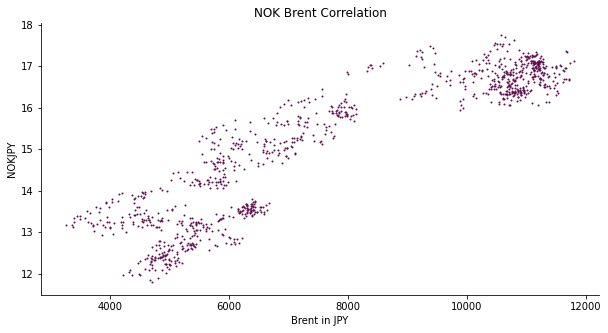

In [ ]:
#identification
#first of first, using scatter plot to visualize the correlation
#lets denote data from 2013-4-25 to 2017-4-25 as estimation horizon/training set
#lets denote data from 2017-4-25 to 2018-4-25 as validation horizon/testing set
ax=plt.figure(figsize=(10,5)).add_subplot(111)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.scatter(df['brent'][df.index<'2017-04-25'],df['nok'][df.index<'2017-04-25'],s=1,c='#5f0f4e')

plt.title('NOK Brent Correlation')
plt.xlabel('Brent in JPY')
plt.ylabel('NOKJPY')
plt.show()

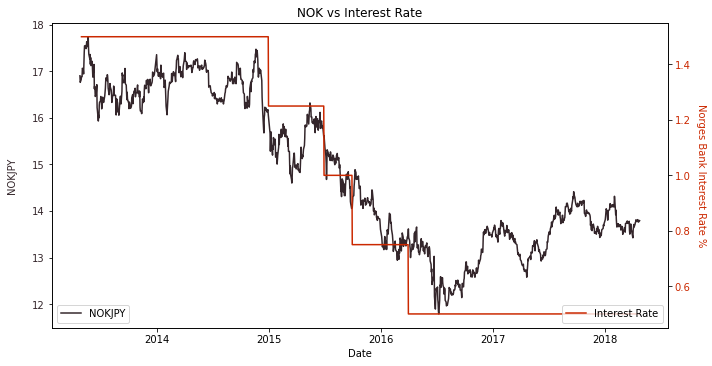

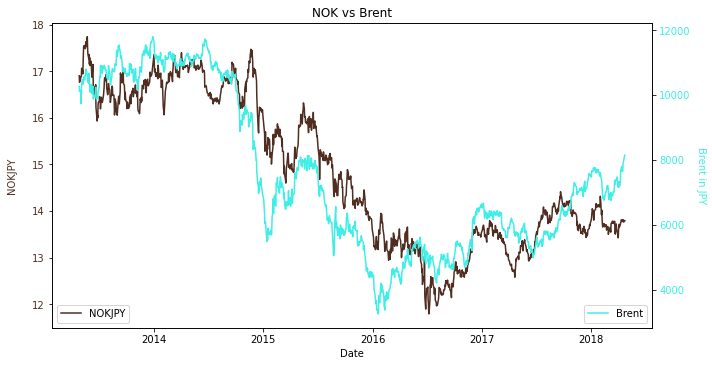

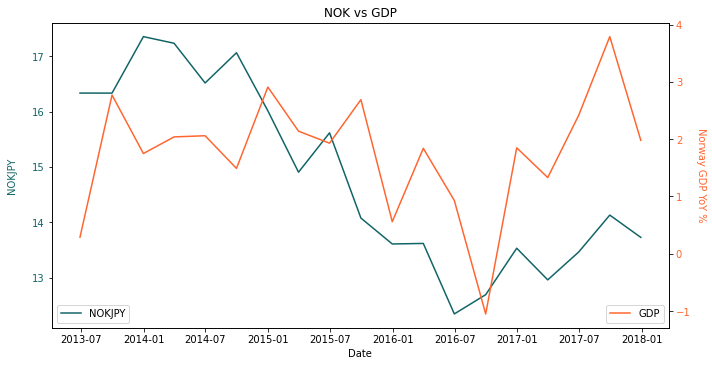

In [ ]:
df.tail()#dual axis plot
def dual_axis_plot(xaxis,data1,data2,fst_color='r',
                    sec_color='b',fig_size=(10,5),
                   x_label='',y_label1='',y_label2='',
                   legend1='',legend2='',grid=False,title=''):

    fig=plt.figure(figsize=fig_size)
    ax=fig.add_subplot(111)


    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label1, color=fst_color)
    ax.plot(xaxis, data1, color=fst_color,label=legend1)
    ax.tick_params(axis='y',labelcolor=fst_color)
    ax.yaxis.labelpad=15

    plt.legend(loc=3)
    ax2 = ax.twinx()

    ax2.set_ylabel(y_label2, color=sec_color,rotation=270)
    ax2.plot(xaxis, data2, color=sec_color,label=legend2)
    ax2.tick_params(axis='y',labelcolor=sec_color)
    ax2.yaxis.labelpad=15

    fig.tight_layout()
    plt.legend(loc=4)
    plt.grid(grid)
    plt.title(title)
    plt.show()

#nok vs ir
dual_axis_plot(df.index,df['nok'],df['interest rate'],
               fst_color='#34262b',sec_color='#cb2800',
               fig_size=(10,5),x_label='Date',
               y_label1='NOKJPY',y_label2='Norges Bank Interest Rate %',
               legend1='NOKJPY',legend2='Interest Rate',
               grid=False,title='NOK vs Interest Rate')

#nok vs brent
dual_axis_plot(df.index,df['nok'],df['brent'],
               fst_color='#4f2d20',sec_color='#3feee6',
               fig_size=(10,5),x_label='Date',
               y_label1='NOKJPY',y_label2='Brent in JPY',
               legend1='NOKJPY',legend2='Brent',
               grid=False,title='NOK vs Brent')

#nok vs gdp
#cuz gdp is released quarterly
#we need to convert nok into quarterly data as well
ind=df['gdp yoy'].dropna().index
dual_axis_plot(df.loc[ind].index,
               df['nok'].loc[ind],
               df['gdp yoy'].dropna(),
               fst_color='#116466',sec_color='#ff652f',
               fig_size=(10,5),x_label='Date',
               y_label1='NOKJPY',y_label2='Norway GDP YoY %',
               legend1='NOKJPY',legend2='GDP',
               grid=False,title='NOK vs GDP')


In [ ]:
df = df.ffill().fillna(df.mean()) ## this filling operations can be vastly improved (stay tuned)

In [ ]:
# You don't have to shift, you are not predicting next day return, just establishing fundamental relationship
# df['nok'][df.index<'2017-04-25'].shift(1).head()

In [ ]:
y

﻿date
2013-04-25          NaN
2013-04-26    16.901885
2013-04-29    16.760666
2013-04-30    16.818312
2013-05-01    16.882766
                ...    
2017-04-18    12.726046
2017-04-19    12.739178
2017-04-20    12.687538
2017-04-21    12.680378
2017-04-24    12.580594
Name: nok, Length: 1031, dtype: float64

In [ ]:
#Now we do our linear regression
x0=pd.concat([df['usd'],df['gbp'],df['eur'],df['brent'],df['causal_size_step200'],df['causal_size_step60'],df['causal_size_step20'],df['causal_size_step10']],axis=1)
x1=sm.add_constant(x0)
x=x1[x1.index<'2017-04-25']
y=df['nok'][df.index<'2017-04-25'].shift(1).bfill()

model=sm.OLS(y,x).fit()
print(model.summary(),'\n')

                            OLS Regression Results                            
Dep. Variable:                    nok   R-squared:                       0.958
Model:                            OLS   Adj. R-squared:                  0.957
Method:                 Least Squares   F-statistic:                     2882.
Date:                Mon, 31 Jan 2022   Prob (F-statistic):               0.00
Time:                        16:09:20   Log-Likelihood:                -360.78
No. Observations:                1031   AIC:                             739.6
Df Residuals:                    1022   BIC:                             784.0
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   1.2322    

Sometimes condition numbers are used (see the appendix). An informal rule of thumb is that if the condition number is 15, multicollinearity is a concern; if it is greater than 30 multicollinearity is a very serious concern. (But again, these are just informal rules of thumb.)

In [ ]:
#from the summary (above) you can tell there is multicollinearity
#the condition number is skyrocketing
#alternatively, i can use elastic net regression to achieve the convergence
m=en(alphas=[0.0001, 0.0005, 0.001, 0.01, 0.1, 1, 10],
     l1_ratio=[.01, .1, .5, .9, .99],  max_iter=5000).fit(x0[x0.index<'2017-04-25'], y)
print(m.intercept_,m.coef_)

3.8681806302685704 [ 0.00288207  0.02039073  0.0282364   0.00049658  0.          0.
 -0.         -0.        ]


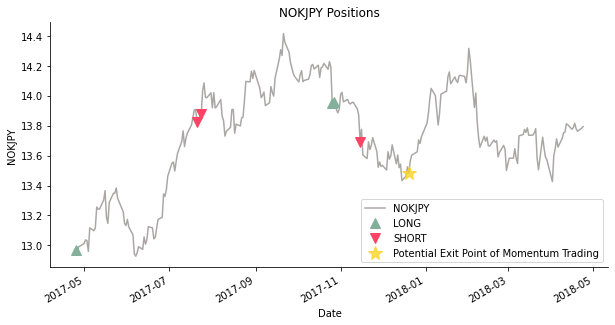

In [ ]:
#calculate the fitted value of nok
df['sk_fit']=(df['usd']*m.coef_[0]+df['gbp']*m.coef_[1]+
                 df['eur']*m.coef_[2]+df['brent']*m.coef_[3]+m.intercept_)


# In[6]:


#getting the residual
df['sk_residual']=df['nok']-df['sk_fit']


#one can always argue what if we eliminate some regressors
#in econometrics, if adding extra variables do not decrease adjusted r squared
#or worsen AIC, BIC
#we should include more information as long as it makes sense

#lets generate signals based on the elastic net
#we set one sigma of the residual as thresholds
#two sigmas of the residual as stop orders
#which is common practise in statistics
upper=np.std(df['sk_residual'][df.index<'2017-04-25'])
lower=-upper

signals=pd.concat([df[i] for i in ['nok', 'usd', 'eur', 'gbp', 'brent', 'sk_fit','sk_residual']], \
                  axis=1)[df.index>='2017-04-25']
signals['fitted']=signals['sk_fit']
del signals['sk_fit']

signals['upper']=signals['fitted']+upper
signals['lower']=signals['fitted']+lower
signals['stop profit']=signals['fitted']+2*upper
signals['stop loss']=signals['fitted']+2*lower
signals['signals']=0

#while doing a traversal
#we apply the rules mentioned before
#if actual price goes beyond upper threshold
#we take a short and bet on its reversion process
#vice versa
#we use cumsum to make sure our signals only get generated
#for the first time condions are met
#when actual price hits the stop order boundary
#we revert our positions
#u may wonder whats next for breaking the boundary
#well, we stop the signal generation algorithm
#we need to recalibrate our model or use other trend following strategies

index=list(signals.columns).index('signals')

for j in range(len(signals)):

    if signals['nok'].iloc[j]>signals['upper'].iloc[j]:
        signals.iloc[j,index]=-1

    if signals['nok'].iloc[j]<signals['lower'].iloc[j]:
        signals.iloc[j,index]=1

    signals['cumsum']=signals['signals'].cumsum()

    if signals['cumsum'].iloc[j]>1 or signals['cumsum'].iloc[j]<-1:
        signals.iloc[j,index]=0

    if signals['nok'].iloc[j]>signals['stop profit'].iloc[j]:
        signals['cumsum']=signals['signals'].cumsum()
        signals.iloc[j,index]=-signals['cumsum'].iloc[j]+1
        signals['cumsum']=signals['signals'].cumsum()
        break

    if signals['nok'].iloc[j]<signals['stop loss'].iloc[j]:
        signals['cumsum']=signals['signals'].cumsum()
        signals.iloc[j,index]=-signals['cumsum'].iloc[j]-1
        signals['cumsum']=signals['signals'].cumsum()
        break


# In[9]:


#next, we plot the usual positions as the first figure
ax=plt.figure(figsize=(10,5)).add_subplot(111)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

signals['nok'].plot(label='NOKJPY',c='#594f4f',alpha=0.5)
ax.plot(signals.loc[signals['signals']>0].index,
         signals['nok'][signals['signals']>0],
         lw=0,marker='^',c='#83af9b',label='LONG', markersize=10)
ax.plot(signals.loc[signals['signals']<0].index,
         signals['nok'][signals['signals']<0],
         lw=0,marker='v',c='#fe4365',label='SHORT', markersize=10)
ax.plot(pd.to_datetime('2017-12-20'),
         signals['nok'].loc['2017-12-20'],
         lw=0,marker='*',c='#f9d423', markersize=15, alpha=0.8,
         label='Potential Exit Point of Momentum Trading')

# plt.axvline('2017/11/15',linestyle=':',c='k',label='Exit')
plt.legend()
plt.title('NOKJPY Positions')
plt.ylabel('NOKJPY')
plt.xlabel('Date')
plt.show()


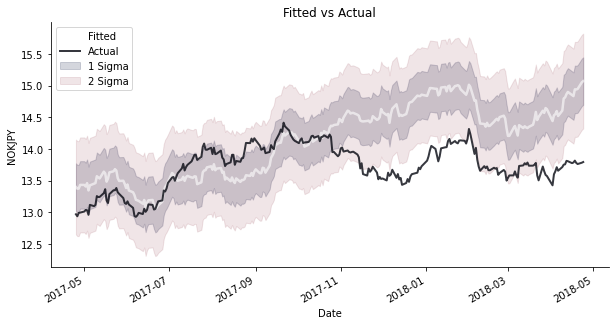

In [ ]:
#the second figure explores thresholds and boundaries for signal generation
#we can see after 2017/11/15, nokjpy price went skyrocketing
#as a data scientist, we must ask why?
#is it a problem of our model identification
#or the fundamental situation of nokjpy or oil changed

ax=plt.figure(figsize=(10,5)).add_subplot(111)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

signals['fitted'].plot(lw=2.5,label='Fitted',c='w',alpha=0.6)
signals['nok'].plot(lw=2,label='Actual',c='#04060f',alpha=0.8)
ax.fill_between(signals.index,signals['upper'],
                signals['lower'],alpha=0.2,label='1 Sigma',color='#2a3457')
ax.fill_between(signals.index,signals['stop profit'],
                signals['stop loss'],alpha=0.1,label='2 Sigma',color='#720017')

plt.legend(loc='best')
plt.title('Fitted vs Actual')
plt.ylabel('NOKJPY')
plt.xlabel('Date')
plt.show()

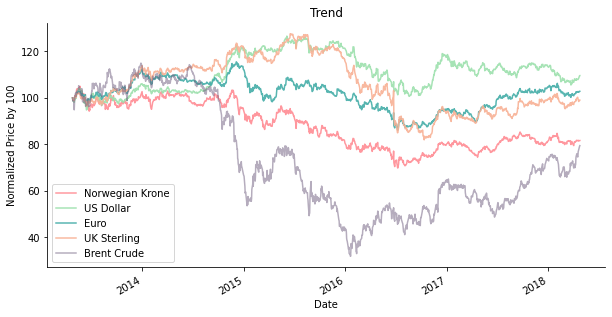

In [ ]:
#if we decompose nokjpy into long term trend and short term random process
#we could clearly see that brent crude price has dominated short term random process
#so what changed the long term trend?
#there are a few possible reasons
#saudi and iran endorsed an extension of production caps on that particular date
#donald trump got elected as potus so he would encourage a depreciated us dollar
#which ultimately pushed up the oil price

# In[12]:

#lets normalize all prices by 100
#its easy to see that nok follows euro
#and economics explanation would be norway is in eea
#its economy heavily relies on eu
ax=plt.figure(figsize=(10,5)).add_subplot(111)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

(df['nok']/df['nok'][0]*100).plot(c='#ff8c94',label='Norwegian Krone',alpha=0.9)
(df['usd']/df['usd'][0]*100).plot(c='#9de0ad',label='US Dollar',alpha=0.9)
(df['eur']/df['eur'][0]*100).plot(c='#45ada8',label='Euro',alpha=0.9)
(df['gbp']/df['gbp'][0]*100).plot(c='#f8b195',label='UK Sterling',alpha=0.9)
(df['brent']/df['brent'][0]*100).plot(c='#6c5b7c',label='Brent Crude',alpha=0.5)

plt.legend(loc='best')
plt.ylabel('Normalized Price by 100')
plt.xlabel('Date')
plt.title('Trend')
plt.show()

In [ ]:
#that still doesnt sound convincable
#lets try cointegration test
#academically we should use johansen test which works on multi dimensions
#unfortunately, there is no johansen test in statsmodels (at the time i wrote this script)
#well, here we go again
#we have to use Engle-Granger two step!


x2=df['eur'][df.index<'2017-04-25']
x3=sm.add_constant(x2)

model=sm.OLS(y,x3).fit()
ero=model.resid

print(adf(ero))
print(model.summary())

(-2.6304210139887494, 0.08687143224904925, 3, 1027, {'1%': -3.4367333690404767, '5%': -2.8643583648001925, '10%': -2.568270618452702}, -757.83914799221)
                            OLS Regression Results                            
Dep. Variable:                    nok   R-squared:                       0.730
Model:                            OLS   Adj. R-squared:                  0.730
Method:                 Least Squares   F-statistic:                     2787.
Date:                Mon, 31 Jan 2022   Prob (F-statistic):          4.25e-295
Time:                        16:11:01   Log-Likelihood:                -1314.0
No. Observations:                1031   AIC:                             2632.
Df Residuals:                    1029   BIC:                             2642.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|   

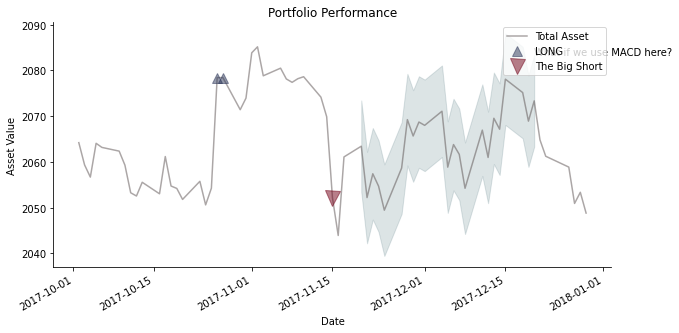

In [ ]:
#unfortunately, the residual hasnt even reached 90% confidence interval
#we cant conclude any cointegration from the test
#still, from the visualization
#we can tell nok and eur are somewhat correlated
#our rsquared suggested euro has the power of 73% explanation on nok

#then lets do a pnl analysis
capital0=2000
positions=100
portfolio=pd.DataFrame(index=signals.index)
portfolio['holding']=signals['nok']*signals['cumsum']*positions
portfolio['cash']=capital0-(signals['nok']*signals['signals']*positions).cumsum()
portfolio['total asset']=portfolio['holding']+portfolio['cash']
portfolio['signals']=signals['signals']


# In[15]:


portfolio=portfolio[portfolio.index>'2017-10-01']
portfolio=portfolio[portfolio.index<'2018-01-01']


# In[16]:


#we plot how our asset value changes over time
ax=plt.figure(figsize=(10,5)).add_subplot(111)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

portfolio['total asset'].plot(c='#594f4f',alpha=0.5,label='Total Asset')
ax.plot(portfolio.loc[portfolio['signals']>0].index,portfolio['total asset'][portfolio['signals']>0],
         lw=0,marker='^',c='#2a3457',label='LONG',markersize=10,alpha=0.5)
ax.plot(portfolio.loc[portfolio['signals']<0].index,portfolio['total asset'][portfolio['signals']<0],
         lw=0,marker='v',c='#720017',label='The Big Short',markersize=15,alpha=0.5)
ax.fill_between(portfolio['2017-11-20':'2017-12-20'].index,
                 (portfolio['total asset']+np.std(portfolio['total asset']))['2017-11-20':'2017-12-20'],
                 (portfolio['total asset']-np.std(portfolio['total asset']))['2017-11-20':'2017-12-20'],
                 alpha=0.2, color='#547980')

plt.text(pd.to_datetime('2017-12-20'),
          (portfolio['total asset']+np.std(portfolio['total asset'])).loc['2017-12-20'],
          'What if we use MACD here?')
# plt.axvline('2017/11/15',linestyle=':',label='Exit',c='#ff847c')
plt.legend()
plt.title('Portfolio Performance')
plt.ylabel('Asset Value')
plt.xlabel('Date')
plt.show()

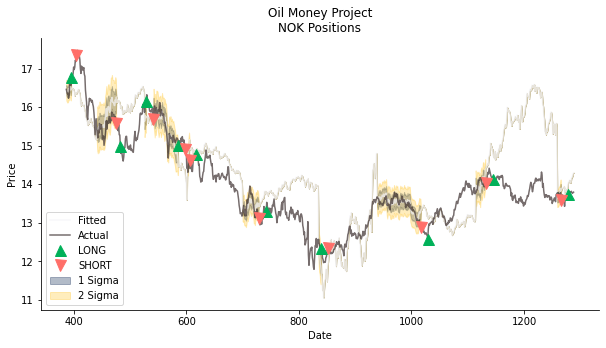

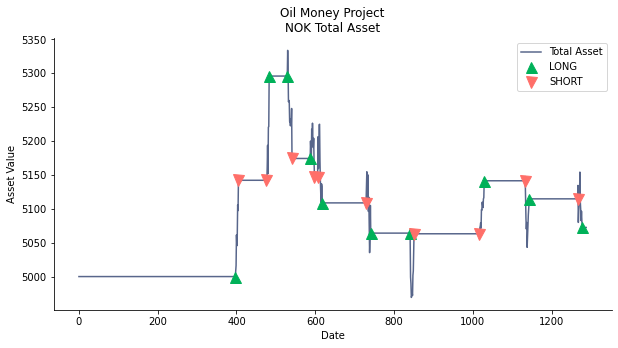

In [ ]:
#surprising when our model is valid for prediction
#its difficult to make money from thresholds oscillating
#when actual price goes beyond stop order boundary
#that is basically the most profitable trade ever
#best to follow up with a momentum strategy
#maybe this is not a statistical arbitrage after all
#the model is a trend following entry indicator
import copy


def oil_money(dataset):

    df=copy.deepcopy(dataset)

    df['signals']=0
    df['pos2 sigma']=0.0
    df['neg2 sigma']=0.0
    df['pos1 sigma']=0.0
    df['neg1 sigma']=0.0
    df['forecast']=0.0

    return df

def signal_generation(dataset,x,y,method, \
                      holding_threshold=10, \
                      stop=0.5,rsquared_threshold=0.7, \
                      train_len=50):

    df=method(dataset)

    #variable holding takes 3 values, -1,0,1
    #0 implies no holding positions
    #1 implies long, -1 implies short
    #when we wanna clear our positions
    #we just reverse the sign of holding
    #which is quite convenient
    holding=0

    #trained is a boolean value
    #it indicates whether the current model is valid
    #in another word,when trained==True, r squared is over 0.7 by default
    #and the regressand is within two sigma range from the fitted value
    trained=False

    #counter counts the days of position holding
    counter=0


    for i in range(train_len,len(df)):

        #when we have uncleared positions
        if holding!=0:

            #when counter exceeds holding threshold
            #we clear our positions and reset all the parameters
            if counter>holding_threshold:
                df.at[i,'signals']=-holding
                holding=0
                trained=False
                counter=0

                #we use continue to skip this round of iteration
                #only if the clearing condition gets triggered
                continue

            #plz note i make stop loss and stop profit symmetric
            #thats why we use absolute value of the spread between current price and entry price
            #usually stop loss and stop profit are asymmetric
            #as ppl cannot take as much loss as profit
            if np.abs( \
                      df[y].iloc[i]-df[y][df['signals']!=0].iloc[-1] \
                      )>=stop:
                df.at[i,'signals']=-holding
                holding=0
                trained=False
                counter=0

                continue

            counter+=1

        else:

            #if we do not have a valid model yet
            #we would keep trying the latest 50 data points
            if not trained:
                X=sm.add_constant(df[x].iloc[i-train_len:i])
                Y=df[y].iloc[i-train_len:i]
                m=sm.OLS(Y,X).fit()

                #if r squared meets the statistical request
                #which is 0.7 by default
                #we can start to build up confidence intervals
                if m.rsquared>rsquared_threshold:
                    trained=True
                    sigma=np.std(Y-m.predict(X))

                    #plz note that we set the forecast and confidence intervals
                    #for every data point after the current one
                    #this would fill in the blank once our model turns invalid
                    #when we have a new valid model
                    #the new forecast and confidence intervals would cover the former one
                    df.at[i:,'forecast']= \
                    m.predict(sm.add_constant(df[x].iloc[i:]))

                    df.at[i:,'pos2 sigma']= \
                    df['forecast'].iloc[i:]+2*sigma

                    df.at[i:,'neg2 sigma']= \
                    df['forecast'].iloc[i:]-2*sigma

                    df.at[i:,'pos1 sigma']= \
                    df['forecast'].iloc[i:]+sigma

                    df.at[i:,'neg1 sigma']= \
                    df['forecast'].iloc[i:]-sigma

            #once we have a valid model
            #we can feel free to generate trading signals
            if trained:
                if df[y].iloc[i]>df['pos2 sigma'].iloc[i]:
                    df.at[i,'signals']=1
                    holding=1

                    #once the positions are entered
                    #we set confidence intervals back to the fitted value
                    #so we could avoid the confusion in our visualization
                    #for instance. if we dont do that,
                    #there would be confidence intervals even when the model is broken
                    #we could have been asking why no trade has been executed,
                    #even when actual price falls out of the confidence intervals?
                    df.at[i:,'pos2 sigma']=df['forecast']
                    df.at[i:,'neg2 sigma']=df['forecast']
                    df.at[i:,'pos1 sigma']=df['forecast']
                    df.at[i:,'neg1 sigma']=df['forecast']

                if df[y].iloc[i]<df['neg2 sigma'].iloc[i]:
                    df.at[i,'signals']=-1
                    holding=-1

                    df.at[i:,'pos2 sigma']=df['forecast']
                    df.at[i:,'neg2 sigma']=df['forecast']
                    df.at[i:,'pos1 sigma']=df['forecast']
                    df.at[i:,'neg1 sigma']=df['forecast']


    return df

def portfolio(signals,close_price,capital0=5000,positions=250):

    portfolio=pd.DataFrame()
    portfolio['close']=signals[close_price]
    portfolio['signals']=signals['signals']

    portfolio['holding']=portfolio['signals'].cumsum()* \
    portfolio['close']*positions

    portfolio['cash']=capital0-(portfolio['signals']* \
                                portfolio['close']*positions).cumsum()

    portfolio['asset']=portfolio['holding']+portfolio['cash']


    return portfolio

#plotting fitted vs actual price with confidence intervals and positions
def plot(signals,close_price):

    data=copy.deepcopy(signals[signals['forecast']!=0])
    ax=plt.figure(figsize=(10,5)).add_subplot(111)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    data['forecast'].plot(label='Fitted',color='#f4f4f8',alpha=0.7)
    data[close_price].plot(label='Actual',color='#3c2f2f',alpha=0.7)

    ax.fill_between(data.index,data['pos1 sigma'], \
                    data['neg1 sigma'],alpha=0.3, \
                    color='#011f4b', label='1 Sigma')
    ax.fill_between(data.index,data['pos2 sigma'], \
                    data['neg2 sigma'],alpha=0.3, \
                    color='#ffc425', label='2 Sigma')

    ax.plot(data.loc[data['signals']==1].index, \
            data[close_price][data['signals']==1],marker='^', \
            c='#00b159',linewidth=0,label='LONG',markersize=11, \
            alpha=1)
    ax.plot(data.loc[data['signals']==-1].index, \
            data[close_price][data['signals']==-1],marker='v', \
            c='#ff6f69',linewidth=0,label='SHORT',markersize=11, \
            alpha=1)

    plt.title(f'Oil Money Project\n{close_price.upper()} Positions')
    plt.legend(loc='best')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.show()

#plotting portfolio performance over time with positions
def profit(portfolio,close_price):

    data=copy.deepcopy(portfolio)
    ax=plt.figure(figsize=(10,5)).add_subplot(111)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    data['asset'].plot(label='Total Asset',color='#58668b')

    ax.plot(data.loc[data['signals']==1].index, \
            data['asset'][data['signals']==1],marker='^', \
            c='#00b159',linewidth=0,label='LONG',markersize=11, \
            alpha=1)
    ax.plot(data.loc[data['signals']==-1].index, \
            data['asset'][data['signals']==-1],marker='v', \
            c='#ff6f69',linewidth=0,label='SHORT',markersize=11, \
            alpha=1)

    plt.title(f'Oil Money Project\n{close_price.upper()} Total Asset')
    plt.legend(loc='best')
    plt.xlabel('Date')
    plt.ylabel('Asset Value')
    plt.show()


#generate signals,monitor portfolio performance
#plot positions and total asset

data=pd.read_csv('https://open-data.s3.filebase.com/brent_crude_nokjpy.csv')
signals=signal_generation(data,'brent','nok',oil_money)
p= portfolio(signals,'nok')
plot(signals,'nok')
profit(p,'nok')

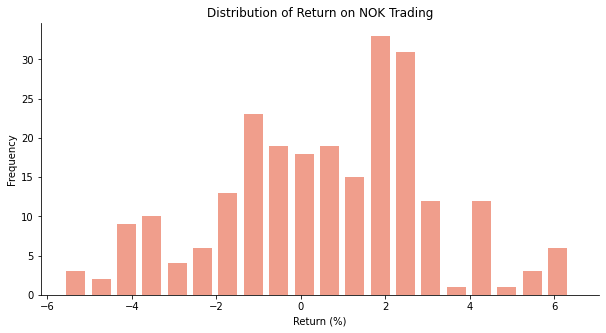

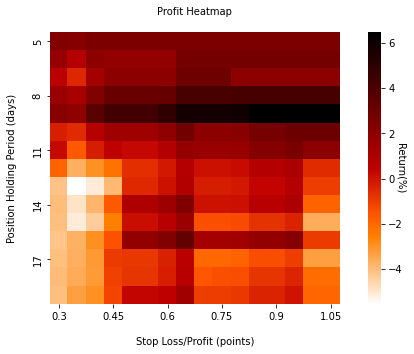

In [ ]:
#but thats not enough, we are not happy with the return
#come on, 2 percent return?
#i may as well as deposit the money into the current account
#and get 0.75% risk free interest rate
#therefore, we gotta try different holding period and stop loss/profit point
#the double loop is very slow, i almost wanna do it in julia
#plz go get a coffee or even lunch and dont wait for it


dic={}
for holdingt in range(5,20):
    for stopp in np.arange(0.3,1.1,0.05):
        signals=signal_generation(data,'brent','nok',oil_money,holding_threshold=holdingt, stop=stopp)

        p=portfolio(signals,'nok')
        dic[holdingt,stopp]=p['asset'].iloc[-1]/p['asset'].iloc[0]-1


profile=pd.DataFrame({'params':list(dic.keys()),'return':list(dic.values())})


# In[18]:

#plotting the distribution of return
#in average the return is 2%
#but we can get -6% and 6% as extreme values
#we want the largest positive return

ax=plt.figure(figsize=(10,5)).add_subplot(111)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
profile['return'].apply(lambda x:x*100).hist(histtype='bar', color='#f09e8c',width=0.45,bins=20)
plt.title('Distribution of Return on NOK Trading')
plt.grid(False)
plt.ylabel('Frequency')
plt.xlabel('Return (%)')
plt.show()


# In[19]:

#plotting the heatmap of return under different parameters
#try to find the optimal parameters to maximize the return

#turn the dataframe into a matrix format first
matrix=pd.DataFrame(columns= [round(i,2) for i in np.arange(0.3,1.1,0.05)])

matrix['index']=np.arange(5,20)
matrix.set_index('index',inplace=True)

for i,j in profile['params']:
    matrix.at[i,round(j,2)]= profile['return'][profile['params']==(i,j)].item()*100

for i in matrix.columns:
    matrix[i]=matrix[i].apply(float)


#plotting
fig=plt.figure(figsize=(10,5))
ax=fig.add_subplot(111)
sns.heatmap(matrix,cmap='gist_heat_r',square=True, xticklabels=3,yticklabels=3)
ax.collections[0].colorbar.set_label('Return(%) \n', rotation=270)
plt.xlabel('\nStop Loss/Profit (points)')
plt.ylabel('Position Holding Period (days)\n')
plt.title('Profit Heatmap\n',fontsize=10)
plt.style.use('default')

#it seems like the return doesnt depend on the stop profit/loss point
#it is correlated with the length of holding period
#the ideal one should be 9 trading days
#as for stop loss/profit point could range from 0.6 to 1.05